In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

transform = torchvision.transforms.ToTensor()
# the gan is modified from version https://github.com/BoyuanJiang/context_encoder_pytorch/
# also from pytorch tutorial https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [2]:
BATCH_SIZE=1

labeled_scene_index = np.arange(106, 134)
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
random.seed(1008)
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
test_idx = labeled_scene_index[26:]

transform = transform = torchvision.transforms.ToTensor()

train_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_idx,
                                  transform=transform,
                                  extra_info=True
                                 )

val_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_idx,
                                  transform=transform,
                                  extra_info=True
                                 )


test_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_idx,
                                  transform=transform,
                                  extra_info=True
                                 )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, 
                                          shuffle=True, num_workers=2, 
                                          collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers=2, 
                                         collate_fn = collate_fn)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers=2, 
                                          collate_fn = collate_fn)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
from VPN_model import PPMBilinear, vpn_model
from VAE_lane import vae_mapping


In [5]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        feature_extractor = torchvision.models.resnet50(pretrained=False)
        feature_extractor = list(feature_extractor.children())[:-3]
        
        generator_list = feature_extractor + [nn.Conv2d(1024, 4000, 4, bias = False),
            nn.BatchNorm2d(4000),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(4000,512, 4,2,1,bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4,2,1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  
            nn.Upsample((128, 153), mode='bilinear', align_corners=False),
            nn.Tanh(),]
        
        self.main = nn.Sequential(*generator_list)
        
    def forward(self, input):
        output = self.main(input)
        return output
 

<All keys matched successfully>

<All keys matched successfully>

In [7]:
class encoder_for_vae(nn.Module):

    def __init__(self):
        super(encoder_for_vae, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(2048, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.mu_dec = nn.Linear(18432, 512)
        self.logvar_dec = nn.Linear(18432, 512)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 18432)
        mu = self.mu_dec(x)
        logvar = self.logvar_dec(x)

        return mu, logvar
    
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class _DecoderBlock(nn.Module):
    """
    Taken from https://github.com/zijundeng/pytorch-semantic-segmentation/blob/master/models/seg_net.py
    """
    def __init__(self, in_channels, out_channels, num_conv_layers, out_activation = 'relu'):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)
class decoder_conv(nn.Module):
    def __init__(self):
        super(decoder_conv, self).__init__()
        self.dec1 = _DecoderBlock(128, 256,2)
        self.dec2 = _DecoderBlock(256, 256,2)
        self.dec3 = _DecoderBlock(256, 256, 2)
        self.dec4 = _DecoderBlock(256, 256, 2)
        self.dec5 = _DecoderBlock(256 ,256, 2)
        self.dec6 = _DecoderBlock(256, 128, 2)
        self.conv_out = nn.Conv2d(128, 1,3 , padding=1)
        self.final_upsample = nn.Upsample((800, 800), mode='bilinear', align_corners=False)
        self.sigmoid = nn.Sigmoid()
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
                
    def forward(self, x):
        x = x.view(-1, 128, 2, 2)
        x = self.dec1(x)
        x= self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.dec5(x)
        x = self.dec6(x)
        x = self.conv_out(x)
        x = self.final_upsample(x)
        x = self.sigmoid(x)
        return x
class vae_mapping(nn.Module):
    def __init__(self):
        super(vae_mapping, self).__init__()
        
        self.feature_extractor = torchvision.models.resnet50(pretrained = False)
        self.encoder = [nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), 
                                 bias = False)] + list(self.feature_extractor.children())[1:-2]
        self.encoder = nn.Sequential(*self.encoder)
        self.encoder_for_vae = encoder_for_vae()
        self.decoder = decoder_conv()
        
    def reparameterize(self, is_training, mu, logvar):
        if is_training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x, is_training, defined_mu = None):
        feature_maps = self.encoder(x)
        mu, logvar = self.encoder_for_vae(feature_maps)
        z = self.reparameterize(is_training, mu, logvar)
        
        pred_map = self.decoder(z)
        
        return pred_map, mu, logvar

<All keys matched successfully>

In [8]:
import copy, time

<All keys matched successfully>

In [42]:
image, _, roadmap, extra  =iter(train_loader).next()

In [43]:
image = torch.stack(image)

In [45]:
image = image.view([6, 3, 256, 306])

In [47]:
image = image.cuda()
feature_extractor = feature_extractor.cuda()
test_output = feature_extractor(image)

In [48]:
test_output.shape

torch.Size([6, 1024, 16, 20])

In [9]:
def train_eval_model(model, dataloaders,criterion, optimizer, 
                num_epochs, checkpoint, to_save, print_every=10, eval_every = 1, to_eval = False):
    
    start_time = time.time()
    if checkpoint:
        pt = torch.load(checkpoint)
        model.load_state_dict(pt['best_model'])
        optimizer.load_state_dict(pt['optimizer'])
        best_loss = pt['best_loss']
        print('loading weights')
    else: 
        best_loss = 1e10
    
    loss_dict = {'train':[], 'val':[]}
    dice_dict = {'train':[], 'val':[]}
    ts_dict = []
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        if (to_eval) and (epoch%eval_every == 0):
            phases = ['train', 'val']
        else:
            phases = ['train']
            
        for phase in phases:
            # print(len(dataloaders[phase]))
            
            curr_loss = 0.0
            curr_dice = 0.0
            
            
            if phase == 'train':
                model.train()

            else:
                model.eval()
                curr_ts = 0.0
                
            for i, (data, _, roadmap, _) in enumerate(dataloaders[phase]):
                inputs = torch.stack(data).to(device)
                target = torch.stack(roadmap).to(device)
                
                optimizer.zero_grad()
                if phase == 'train':
                    with torch.set_grad_enabled(phase=='train'):
                        outputs = model(inputs)
                        loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
                        loss.backward()
                        optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
                    
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), outputs.cpu().squeeze(1))
                curr_loss += loss.item()
                curr_dice += dice_score
                if phase == 'val':
                    curr_ts += compute_ts_road_map(target.cpu(), outputs.cpu().squeeze(1))

            
            loss_dict[phase].append(curr_loss/len(dataloaders[phase]))
            dice_dict[phase].append(curr_dice/len(dataloaders[phase]))
            
            print('current epoch %s composite loss is %f'%(phase, curr_loss))
            print('current epoch %s dice coef is %f'%(phase, curr_dice))
            print('%sing 1 epoch takes %f min'%(phase, (time.time() - epoch_start)/60))
            
            if phase == 'val':
                ts_dict.append(curr_ts/len(dataloaders[phase]))
                print('current ts is %f'%(curr_ts/len(dataloaders[phase])))
                
                # val: after finishing 1 epoch
                if(curr_loss/len(dataloaders[phase])) < best_loss:
                    print('saving best model')
                    checkpt= {'best_model': model.state_dict(),
                                  'optimizer': optimizer.state_dict(), 
                                  'best_loss': curr_loss/len(dataloaders[phase])}
                    torch.save(checkpt, to_save)
                    best_loss = curr_loss/len(dataloaders[phase])
                                 
        if epoch %print_every == 0:
            print('printing test image')
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [173, 289, 441, 361, 9]
            for fig_i, i in enumerate(test_idx):
                inputs = val_set[i][0].unsqueeze(0).to(device)
                with torch.no_grad():
                    outputs = model(inputs).cpu().squeeze().detach()

                ax[fig_i, 0].imshow(val_set[i][2].cpu())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            plt.show()
            
    print('This training takes ', time.time() - start_time)
    
    for key in list(loss_dict.keys()):
        if len(loss_dict[key]) > 0:
            fig = plt.figure()
            plt.plot(loss_dict[key])
            plt.title('%s Loss per epoch'%(key))
            plt.show()
    for key in list(dice_dict.keys()):
        if len(dice_dict[key]) > 0:
            fig = plt.figure()
            plt.plot(dice_dict[key])
            plt.title('%s Dice Score per epoch' %(key))
            plt.show()
    fig = plt.figure()
    plt.plot(ts_dict)
    plt.title('ts score for validation')
    plt.show()

    
    
    return model, loss_dict, dice_dict, ts_dict
    

In [10]:
GAN_checkpoint = torch.load('/scratch/ht1162/DLResult/pre_task_inpainting.pth')
netG = Generator().to(device)
#netG = netG.load_state_dict(GAN_checkpoint['netG'])

inpainting_weights = GAN_checkpoint['netG']
netG.load_state_dict(inpainting_weights)
pretask_feature_extractor = netG.main[:7]

In [11]:
feature_extractor = torchvision.models.resnet50(pretrained=False)
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-3])

In [12]:
feature_extractor.load_state_dict(pretask_feature_extractor.state_dict())

<All keys matched successfully>

In [13]:
vae_checkpoint = torch.load('/scratch/ht1162/DLResult/vae_pretrain_lane3.pth')
vae_model = vae_mapping()
vae_model.load_state_dict(vae_checkpoint['best_model'])


<All keys matched successfully>

In [14]:
vae_weights = copy.deepcopy(vae_model.decoder.dec6.state_dict())


In [15]:
decoder  =PPMBilinear(fc_dim=1024)
decoder.conv_last[1].load_state_dict(vae_weights)

<All keys matched successfully>

In [16]:
for param in feature_extractor.parameters():
    param.requires_grad = True
for param in decoder.parameters():
    param.requires_grad = True


DIM1=16
DIM2=20
my_model = vpn_model(DIM1, DIM2, feature_extractor, decoder)
my_model = my_model.to(device)

for param in my_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)


In [69]:
mini_set, _ = torch.utils.data.random_split(train_set, [5, len(train_set) - 5])
mini_val, _ = torch.utils.data.random_split(val_set, [3, len(val_set)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

In [18]:
#mini_loaders = {'train': mini_loader, 'val': mini_val_loader}
dataloaders = {'train': train_loader, 'val': val_loader}

Epoch 1/40
----------
current epoch train composite loss is 936.564422
current epoch train dice coef is 917.718079
training 1 epoch takes 23.106650 min
current epoch val composite loss is 175.151000
current epoch val dice coef is 164.424454
valing 1 epoch takes 24.519274 min
current ts is 0.492016
saving best model
printing test image


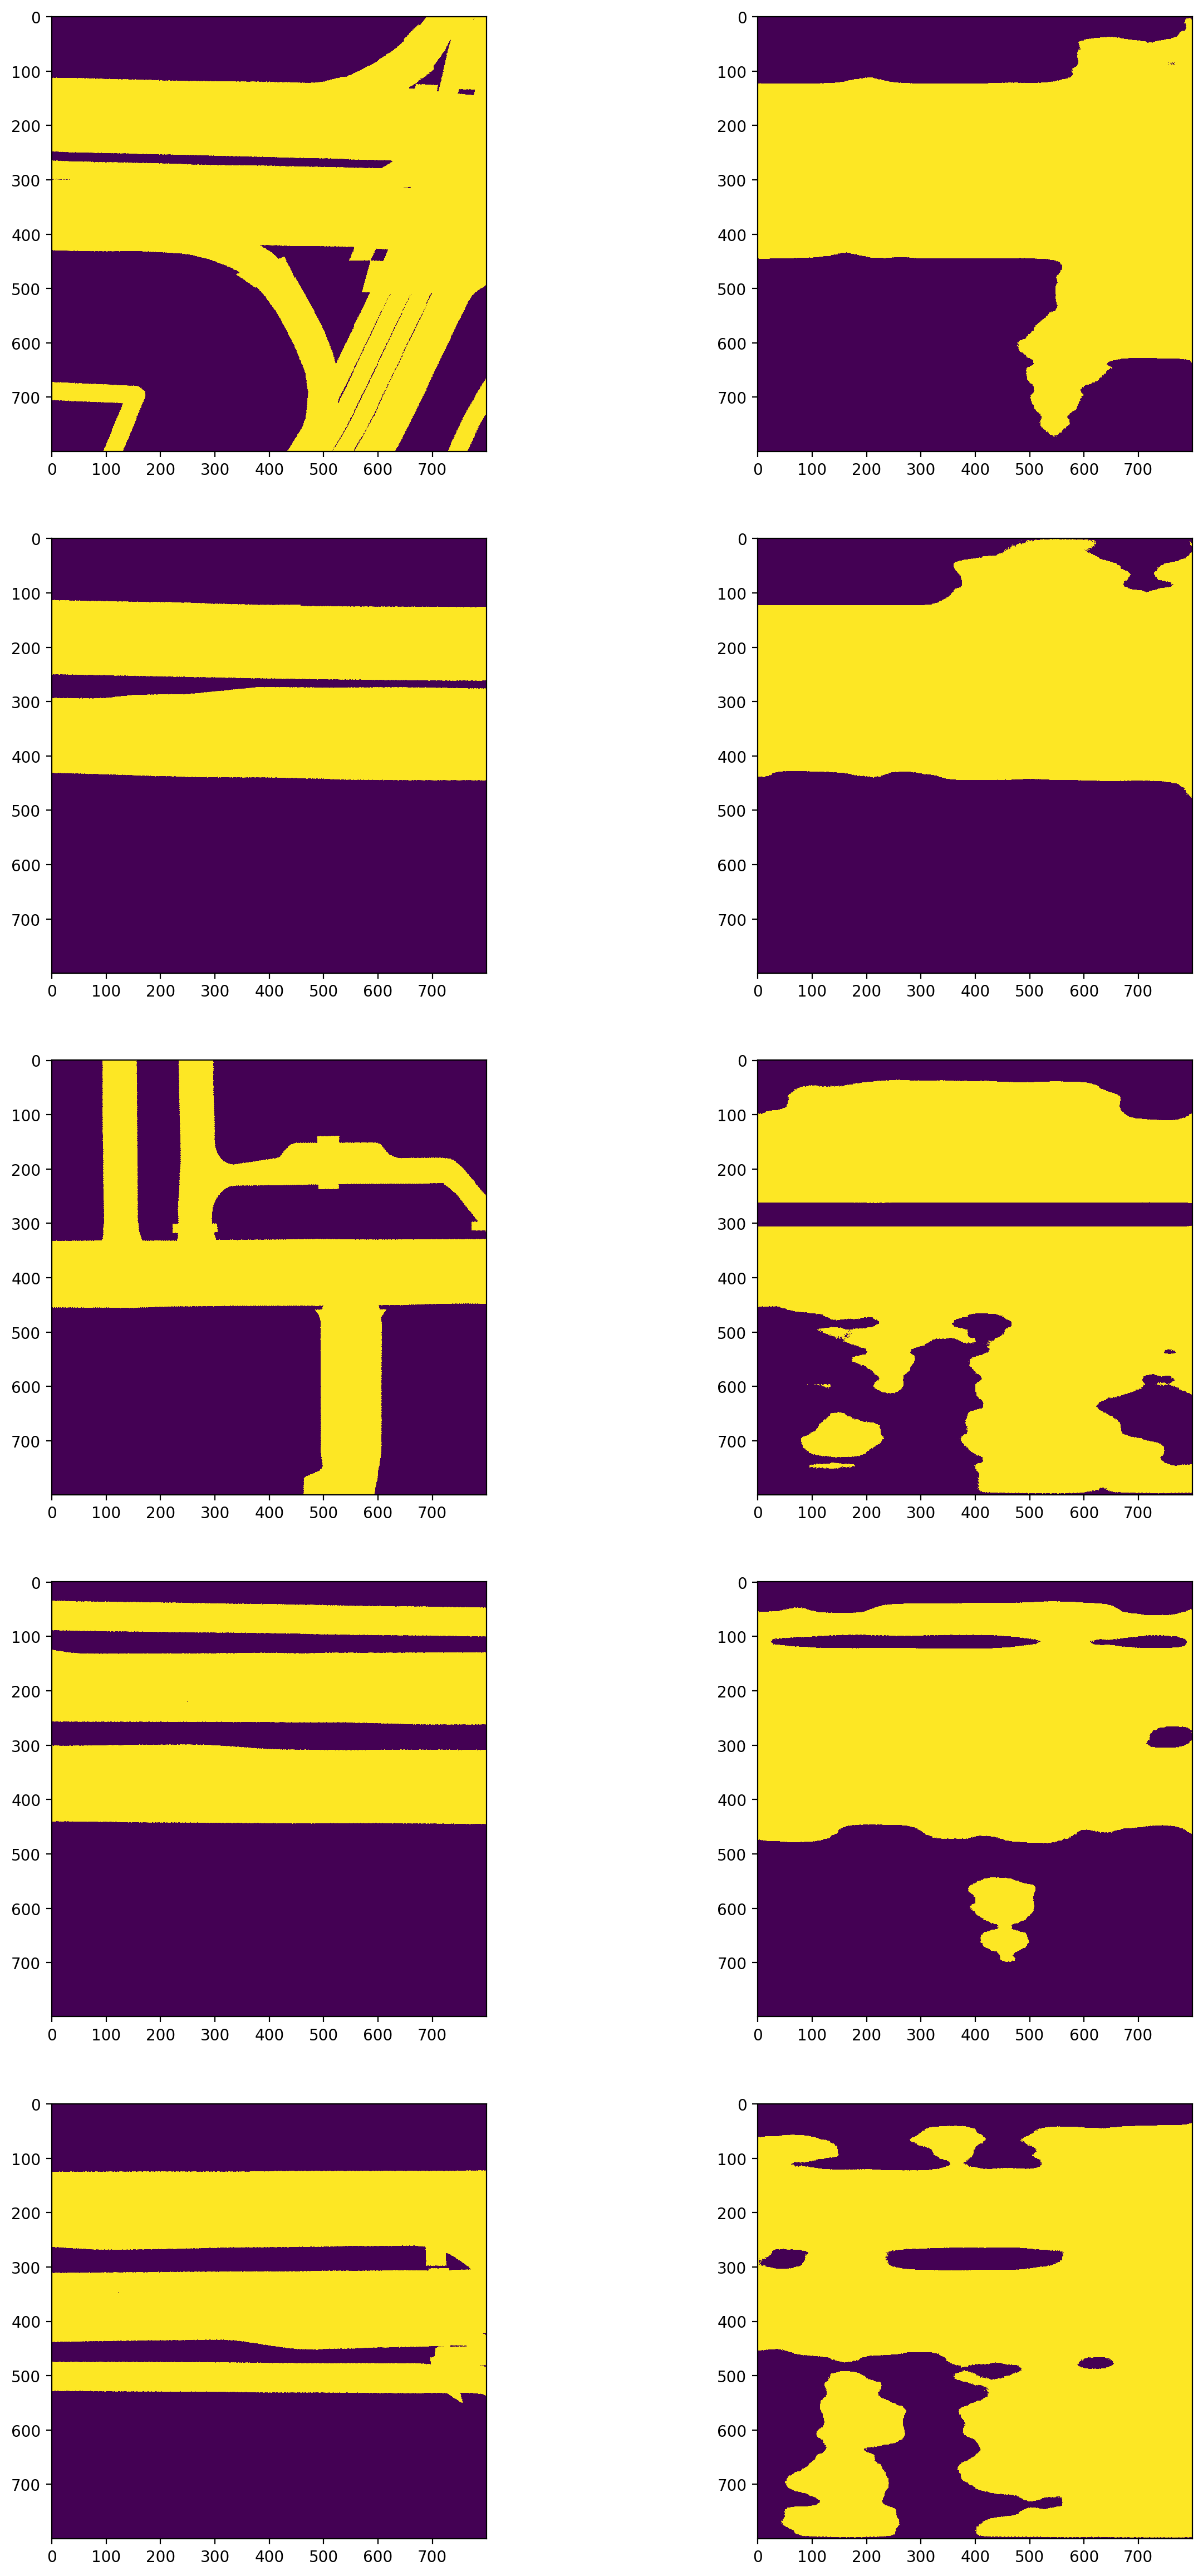

Epoch 2/40
----------
current epoch train composite loss is 759.977015
current epoch train dice coef is 1006.010376
training 1 epoch takes 23.104158 min
current epoch val composite loss is 166.207148
current epoch val dice coef is 168.896500
valing 1 epoch takes 24.512722 min
current ts is 0.511981
saving best model
Epoch 3/40
----------
current epoch train composite loss is 632.346081
current epoch train dice coef is 1069.826538
training 1 epoch takes 23.076390 min
current epoch val composite loss is 153.426201
current epoch val dice coef is 175.286804
valing 1 epoch takes 24.483804 min
current ts is 0.542716
saving best model
Epoch 4/40
----------
current epoch train composite loss is 527.388392
current epoch train dice coef is 1122.307617
training 1 epoch takes 23.065159 min
current epoch val composite loss is 142.048819
current epoch val dice coef is 180.975555
valing 1 epoch takes 24.474996 min
current ts is 0.573267
saving best model
Epoch 5/40
----------
current epoch train comp

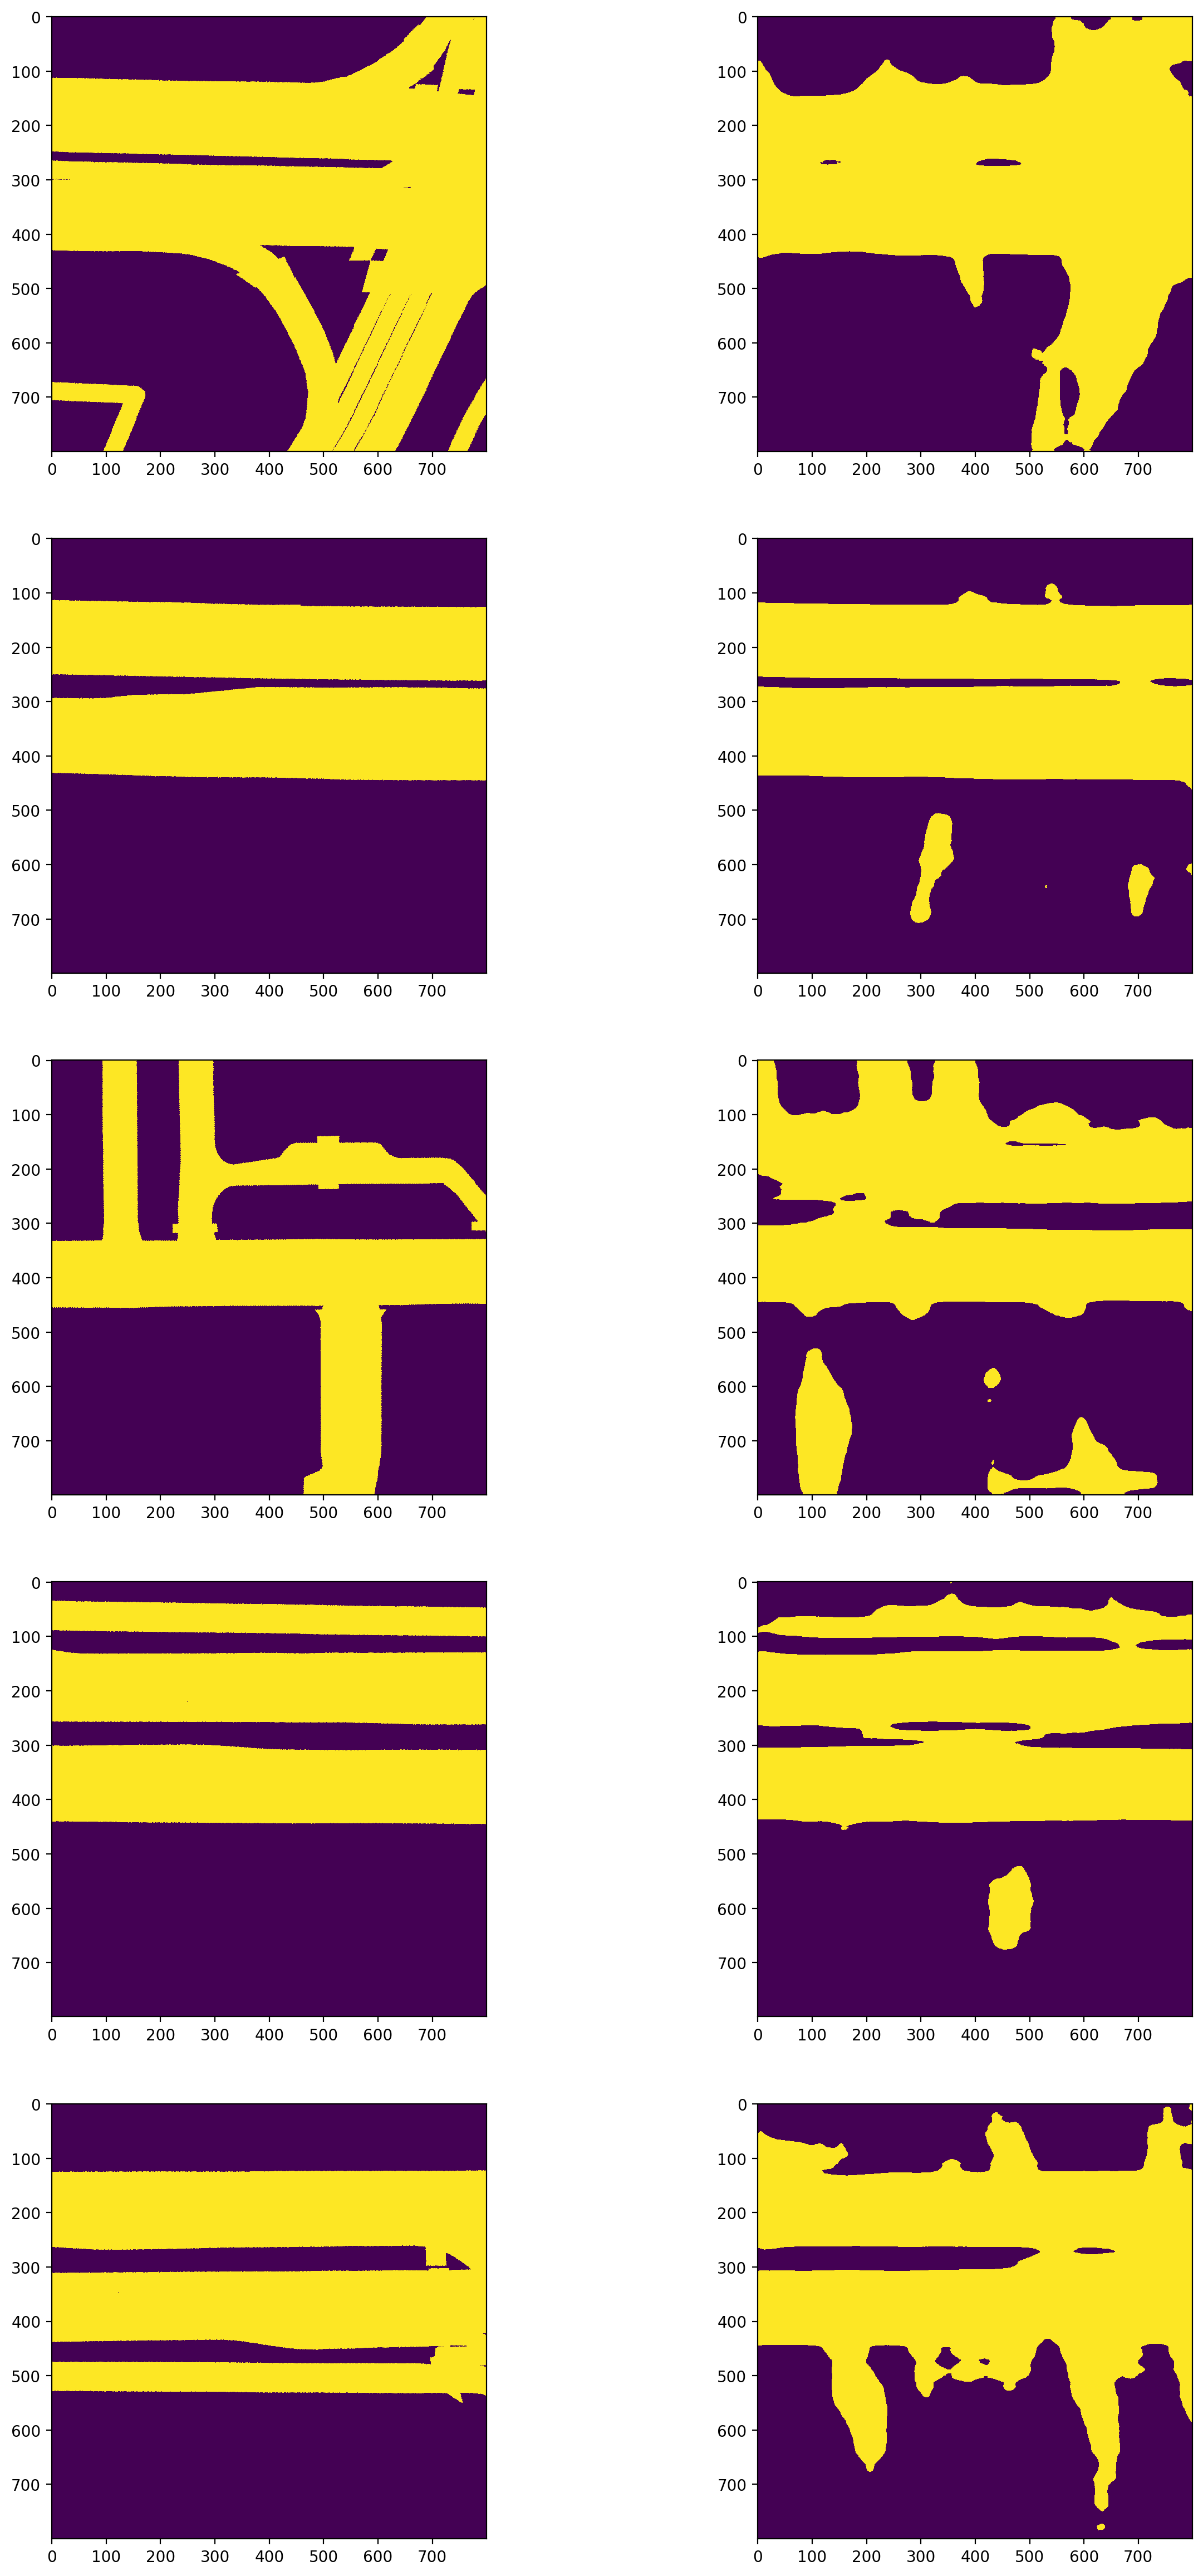

Epoch 12/40
----------
current epoch train composite loss is 141.865114
current epoch train dice coef is 1315.067993
training 1 epoch takes 23.099914 min
current epoch val composite loss is 98.314982
current epoch val dice coef is 202.842545
valing 1 epoch takes 24.514577 min
current ts is 0.693870
saving best model
Epoch 13/40
----------
current epoch train composite loss is 124.744112
current epoch train dice coef is 1323.628784
training 1 epoch takes 23.088880 min
current epoch val composite loss is 95.726378
current epoch val dice coef is 204.136688
valing 1 epoch takes 24.501633 min
current ts is 0.700454
saving best model
Epoch 14/40
----------
current epoch train composite loss is 110.543773
current epoch train dice coef is 1330.728027
training 1 epoch takes 22.996039 min
current epoch val composite loss is 92.546640
current epoch val dice coef is 205.726715
valing 1 epoch takes 24.409529 min
current ts is 0.712144
saving best model
Epoch 15/40
----------
current epoch train com

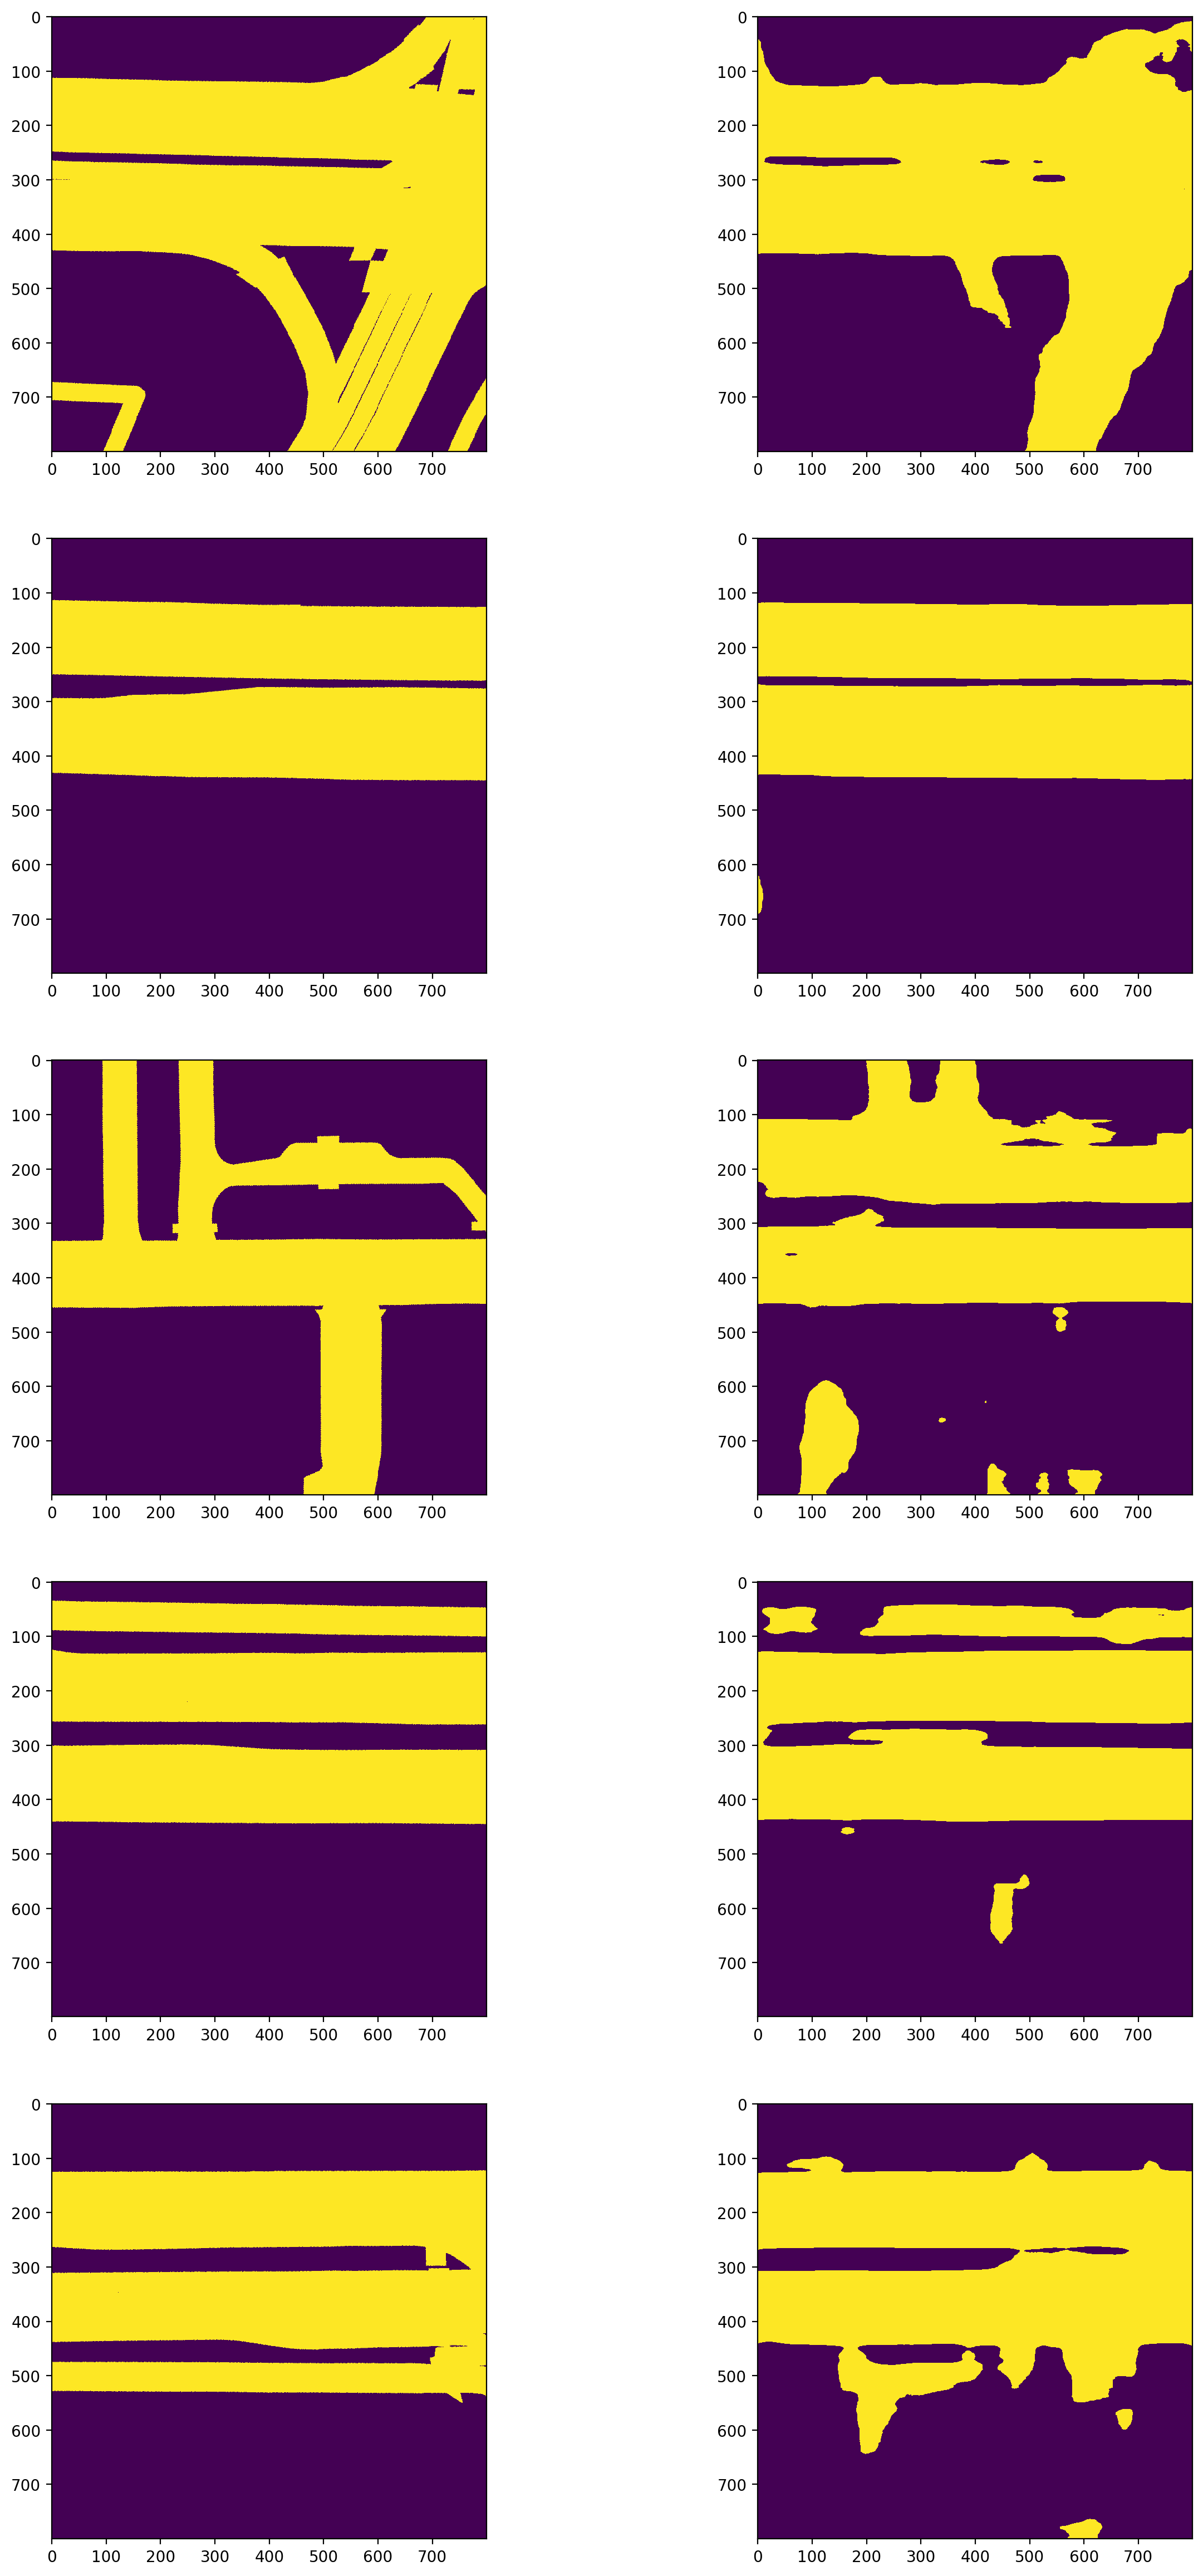

Epoch 22/40
----------
current epoch train composite loss is 58.670407
current epoch train dice coef is 1356.664673
training 1 epoch takes 23.084867 min
current epoch val composite loss is 89.539498
current epoch val dice coef is 207.230179
valing 1 epoch takes 24.501916 min
current ts is 0.721717
Epoch 23/40
----------
current epoch train composite loss is 55.327077
current epoch train dice coef is 1358.337158
training 1 epoch takes 23.068499 min
current epoch val composite loss is 86.835223
current epoch val dice coef is 208.582336
valing 1 epoch takes 24.485699 min
current ts is 0.729516
Epoch 24/40
----------
current epoch train composite loss is 53.295196
current epoch train dice coef is 1359.352905
training 1 epoch takes 23.098322 min
current epoch val composite loss is 86.491240
current epoch val dice coef is 208.754471
valing 1 epoch takes 24.501915 min
current ts is 0.730731
saving best model
Epoch 25/40
----------
current epoch train composite loss is 51.033748
current epoch 

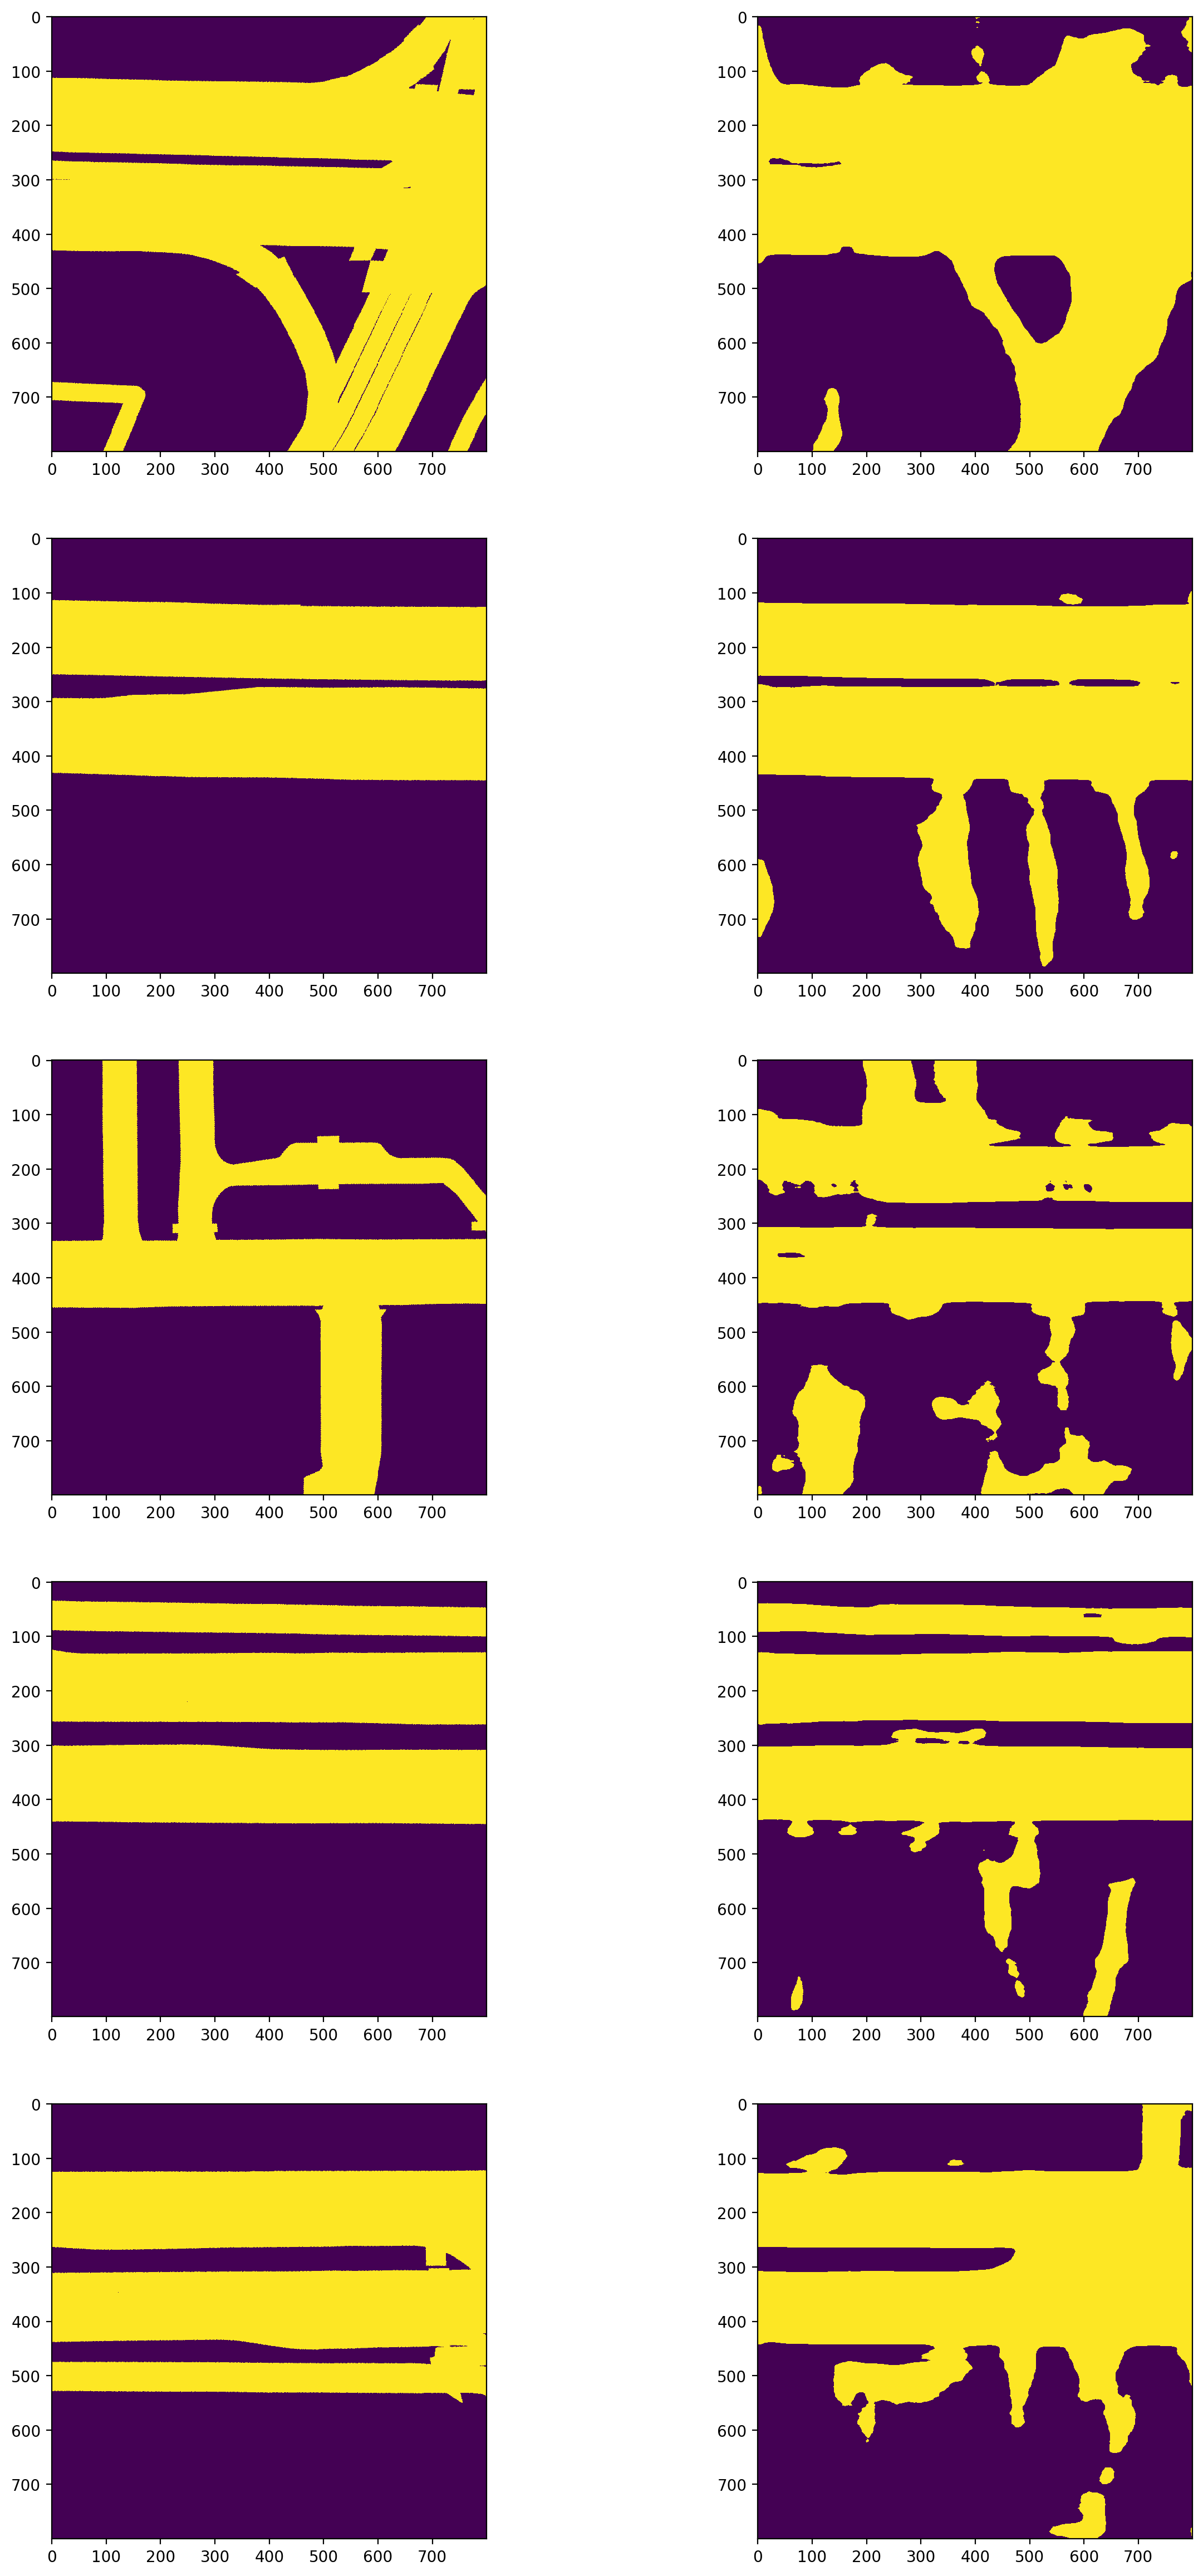

Epoch 32/40
----------
current epoch train composite loss is 41.311621
current epoch train dice coef is 1365.344482
training 1 epoch takes 23.065335 min
current epoch val composite loss is 86.469469
current epoch val dice coef is 208.765289
valing 1 epoch takes 24.490044 min
current ts is 0.731154
Epoch 33/40
----------
current epoch train composite loss is 40.611713
current epoch train dice coef is 1365.693970
training 1 epoch takes 23.045335 min
current epoch val composite loss is 91.825396
current epoch val dice coef is 206.087204
valing 1 epoch takes 24.465941 min
current ts is 0.713740
Epoch 34/40
----------
current epoch train composite loss is 39.271596
current epoch train dice coef is 1366.362305
training 1 epoch takes 22.959809 min
current epoch val composite loss is 87.330003
current epoch val dice coef is 208.334915
valing 1 epoch takes 24.374626 min
current ts is 0.730060
Epoch 35/40
----------
current epoch train composite loss is 38.739287
current epoch train dice coef is

In [ ]:
model, loss_dict, dice_dict, ts_dict = train_eval_model(my_model, dataloaders, 
                                                        dice_loss, optimizer, 
                                                        num_epochs=40, checkpoint=None, 
                                                        to_save = '/scratch/ht1162/DLResult/inpainting_resnet50_w_vae.pth', 
                                                        print_every=10, 
                                                        eval_every = 1, to_eval = True)

Epoch 1/40
----------
current epoch train composite loss is 944.386857
current epoch train dice coef is 913.807556
training 1 epoch takes 22.854897 min
current epoch val composite loss is 176.434646
current epoch val dice coef is 163.782684
valing 1 epoch takes 24.290355 min
current ts is 0.488317
saving best model
printing test image


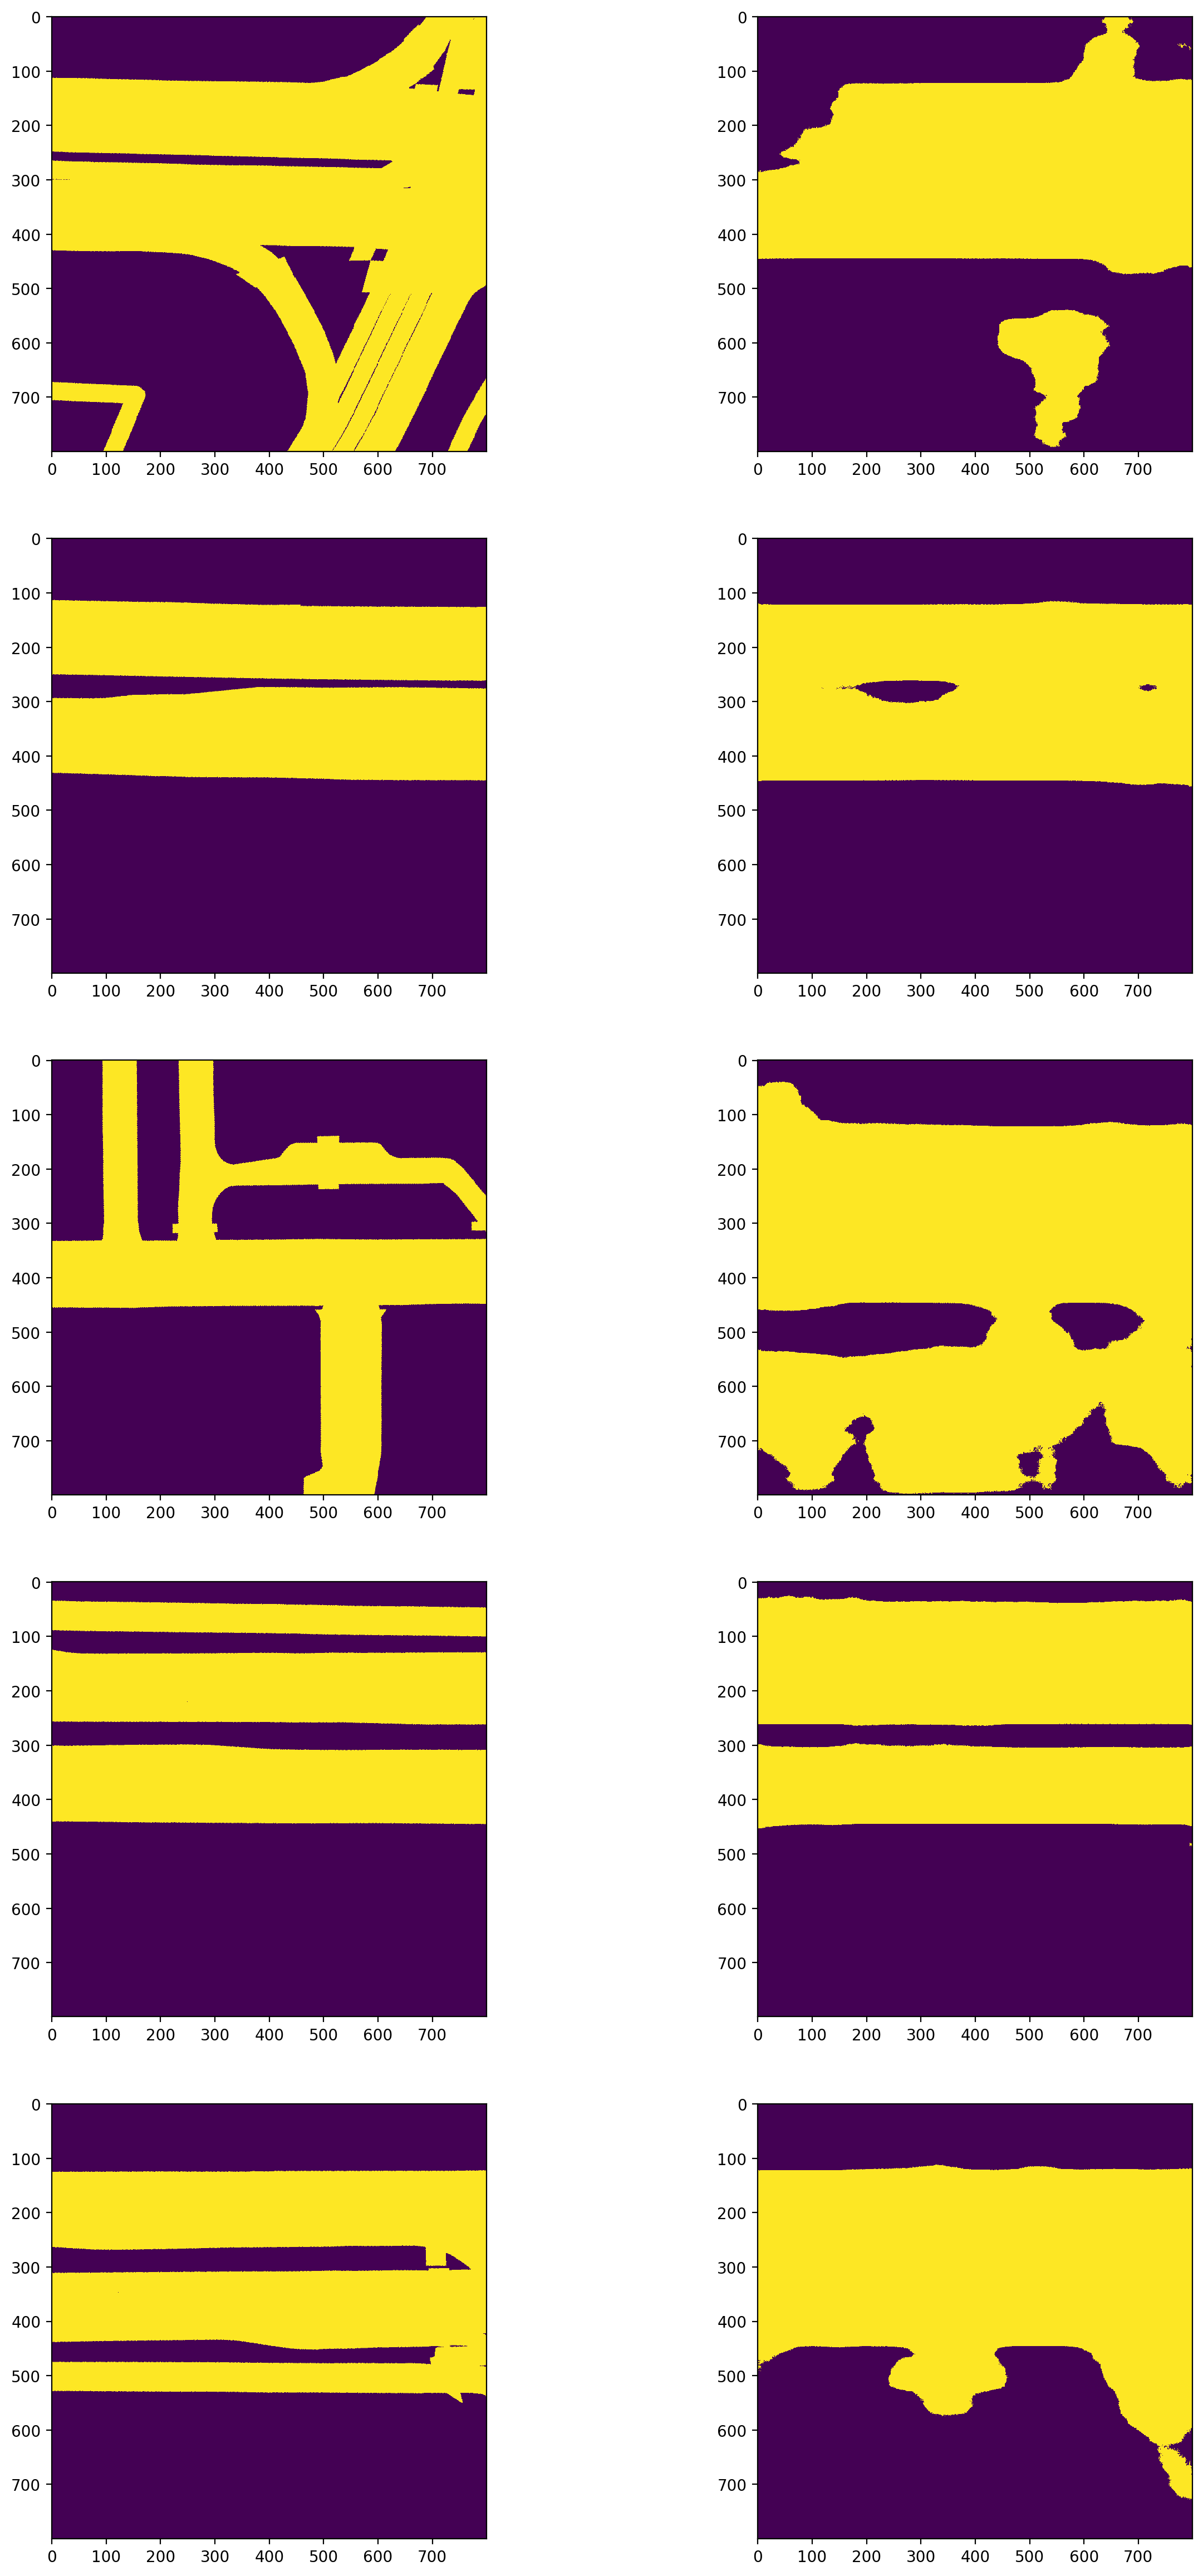

Epoch 2/40
----------
current epoch train composite loss is 766.783462
current epoch train dice coef is 1002.607422
training 1 epoch takes 22.814283 min
current epoch val composite loss is 165.283734
current epoch val dice coef is 169.358109
valing 1 epoch takes 24.247832 min
current ts is 0.514994
saving best model
Epoch 3/40
----------
current epoch train composite loss is 634.703906
current epoch train dice coef is 1068.647705
training 1 epoch takes 22.818432 min
current epoch val composite loss is 158.819558
current epoch val dice coef is 172.590271
valing 1 epoch takes 24.237628 min
current ts is 0.530906
saving best model
Epoch 4/40
----------
current epoch train composite loss is 528.929344
current epoch train dice coef is 1121.536011
training 1 epoch takes 22.969723 min
current epoch val composite loss is 152.081444
current epoch val dice coef is 175.959290
valing 1 epoch takes 24.410084 min
current ts is 0.547689
saving best model
Epoch 5/40
----------
current epoch train comp

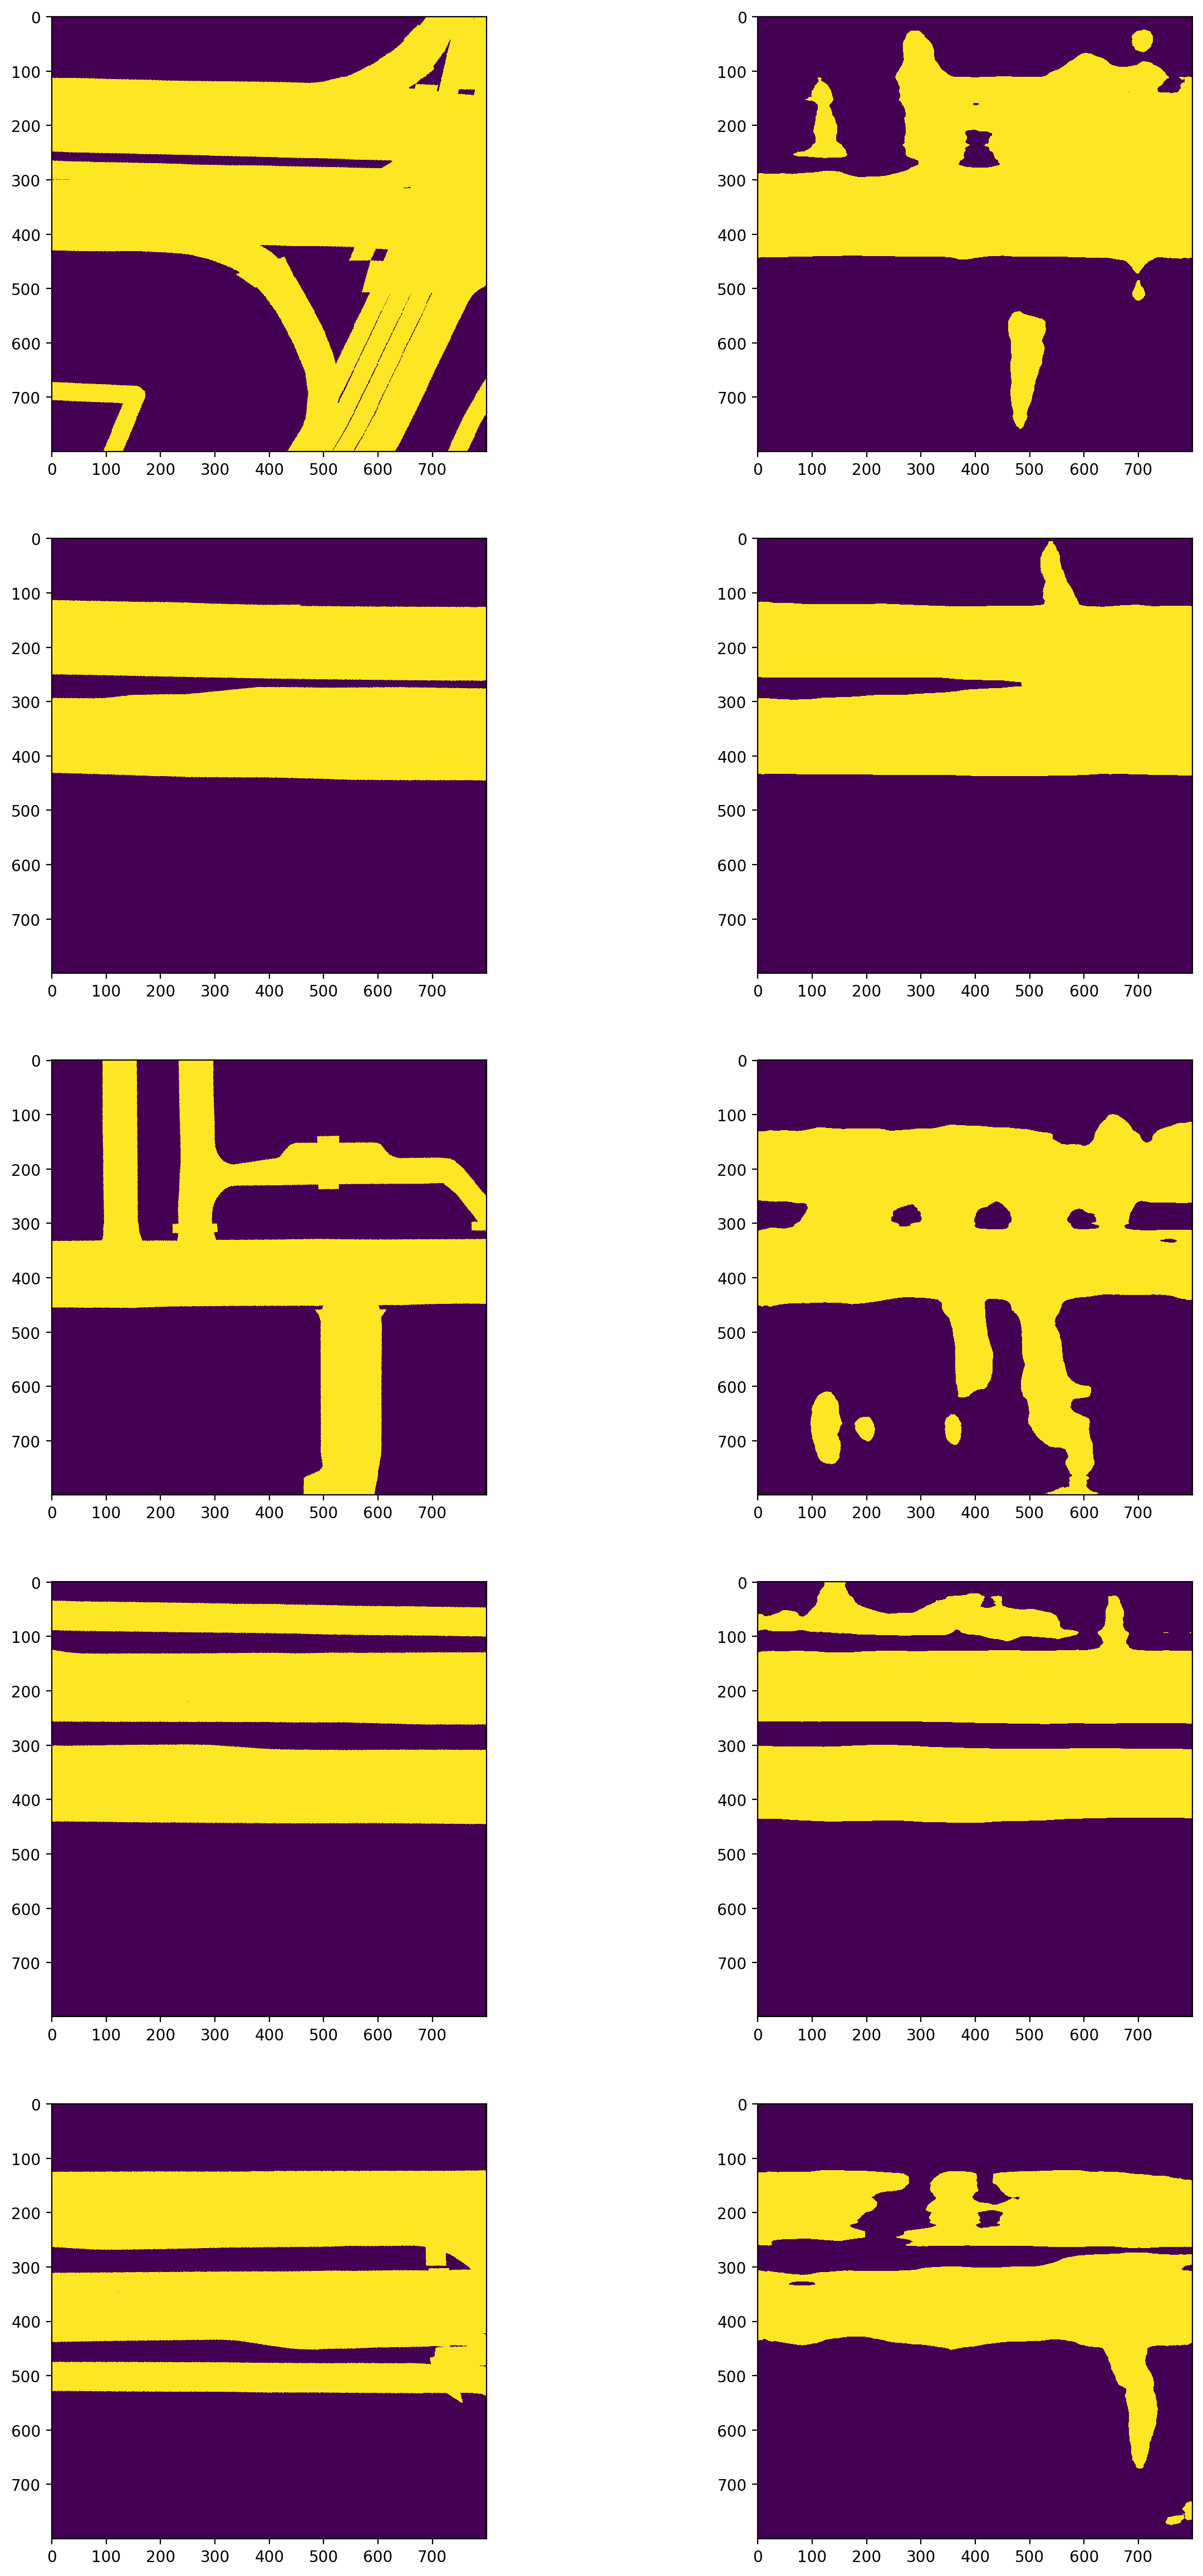

Epoch 12/40
----------
current epoch train composite loss is 142.781403
current epoch train dice coef is 1314.609741
training 1 epoch takes 23.028081 min
current epoch val composite loss is 105.075510
current epoch val dice coef is 199.462265
valing 1 epoch takes 24.464163 min
current ts is 0.676537
saving best model
Epoch 13/40
----------
current epoch train composite loss is 125.199501
current epoch train dice coef is 1323.398315
training 1 epoch takes 23.079966 min
current epoch val composite loss is 108.967312
current epoch val dice coef is 197.516281
valing 1 epoch takes 24.554572 min
current ts is 0.663587
Epoch 14/40
----------
current epoch train composite loss is 111.290573
current epoch train dice coef is 1330.355347
training 1 epoch takes 23.084118 min
current epoch val composite loss is 105.559439
current epoch val dice coef is 199.220367
valing 1 epoch takes 24.513277 min
current ts is 0.674976
Epoch 15/40
----------
current epoch train composite loss is 100.156623
current

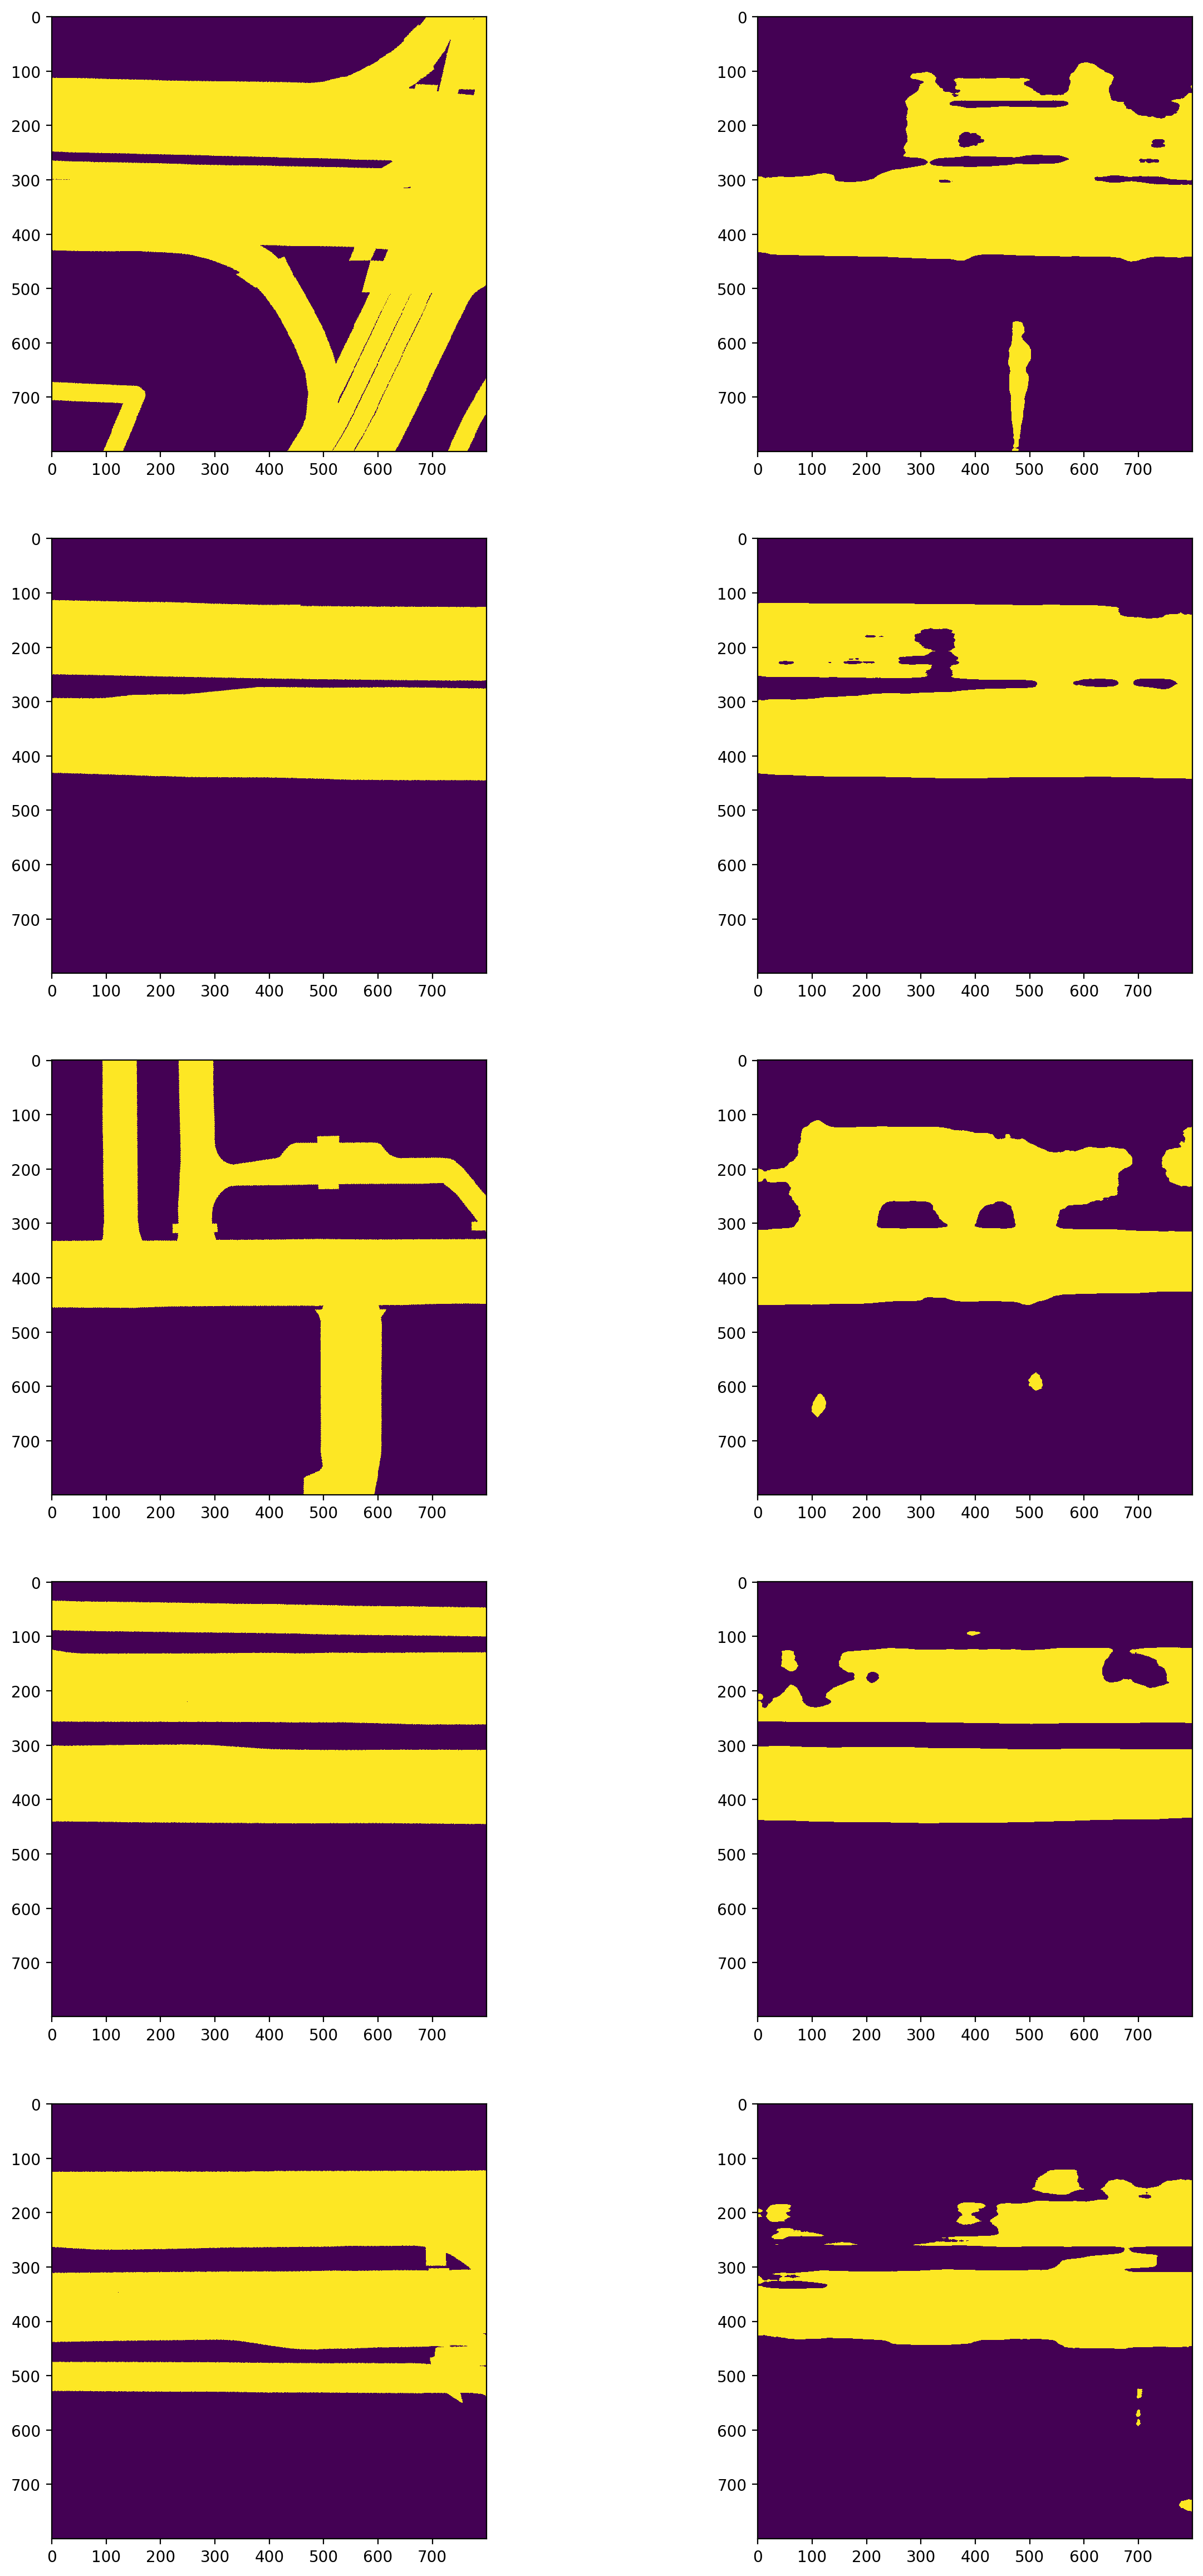

Epoch 22/40
----------
current epoch train composite loss is 59.303304
current epoch train dice coef is 1356.348267
training 1 epoch takes 23.034236 min
current epoch val composite loss is 104.786489
current epoch val dice coef is 199.606644
valing 1 epoch takes 24.463726 min
current ts is 0.677503
Epoch 23/40
----------
current epoch train composite loss is 56.527083
current epoch train dice coef is 1357.736328
training 1 epoch takes 23.014868 min
current epoch val composite loss is 99.433004
current epoch val dice coef is 202.283524
valing 1 epoch takes 24.438905 min
current ts is 0.691875
saving best model
Epoch 24/40
----------
current epoch train composite loss is 54.114488
current epoch train dice coef is 1358.941772
training 1 epoch takes 23.040589 min
current epoch val composite loss is 99.733047
current epoch val dice coef is 202.133484
valing 1 epoch takes 24.465137 min
current ts is 0.692543
Epoch 25/40
----------
current epoch train composite loss is 51.780845
current epoch

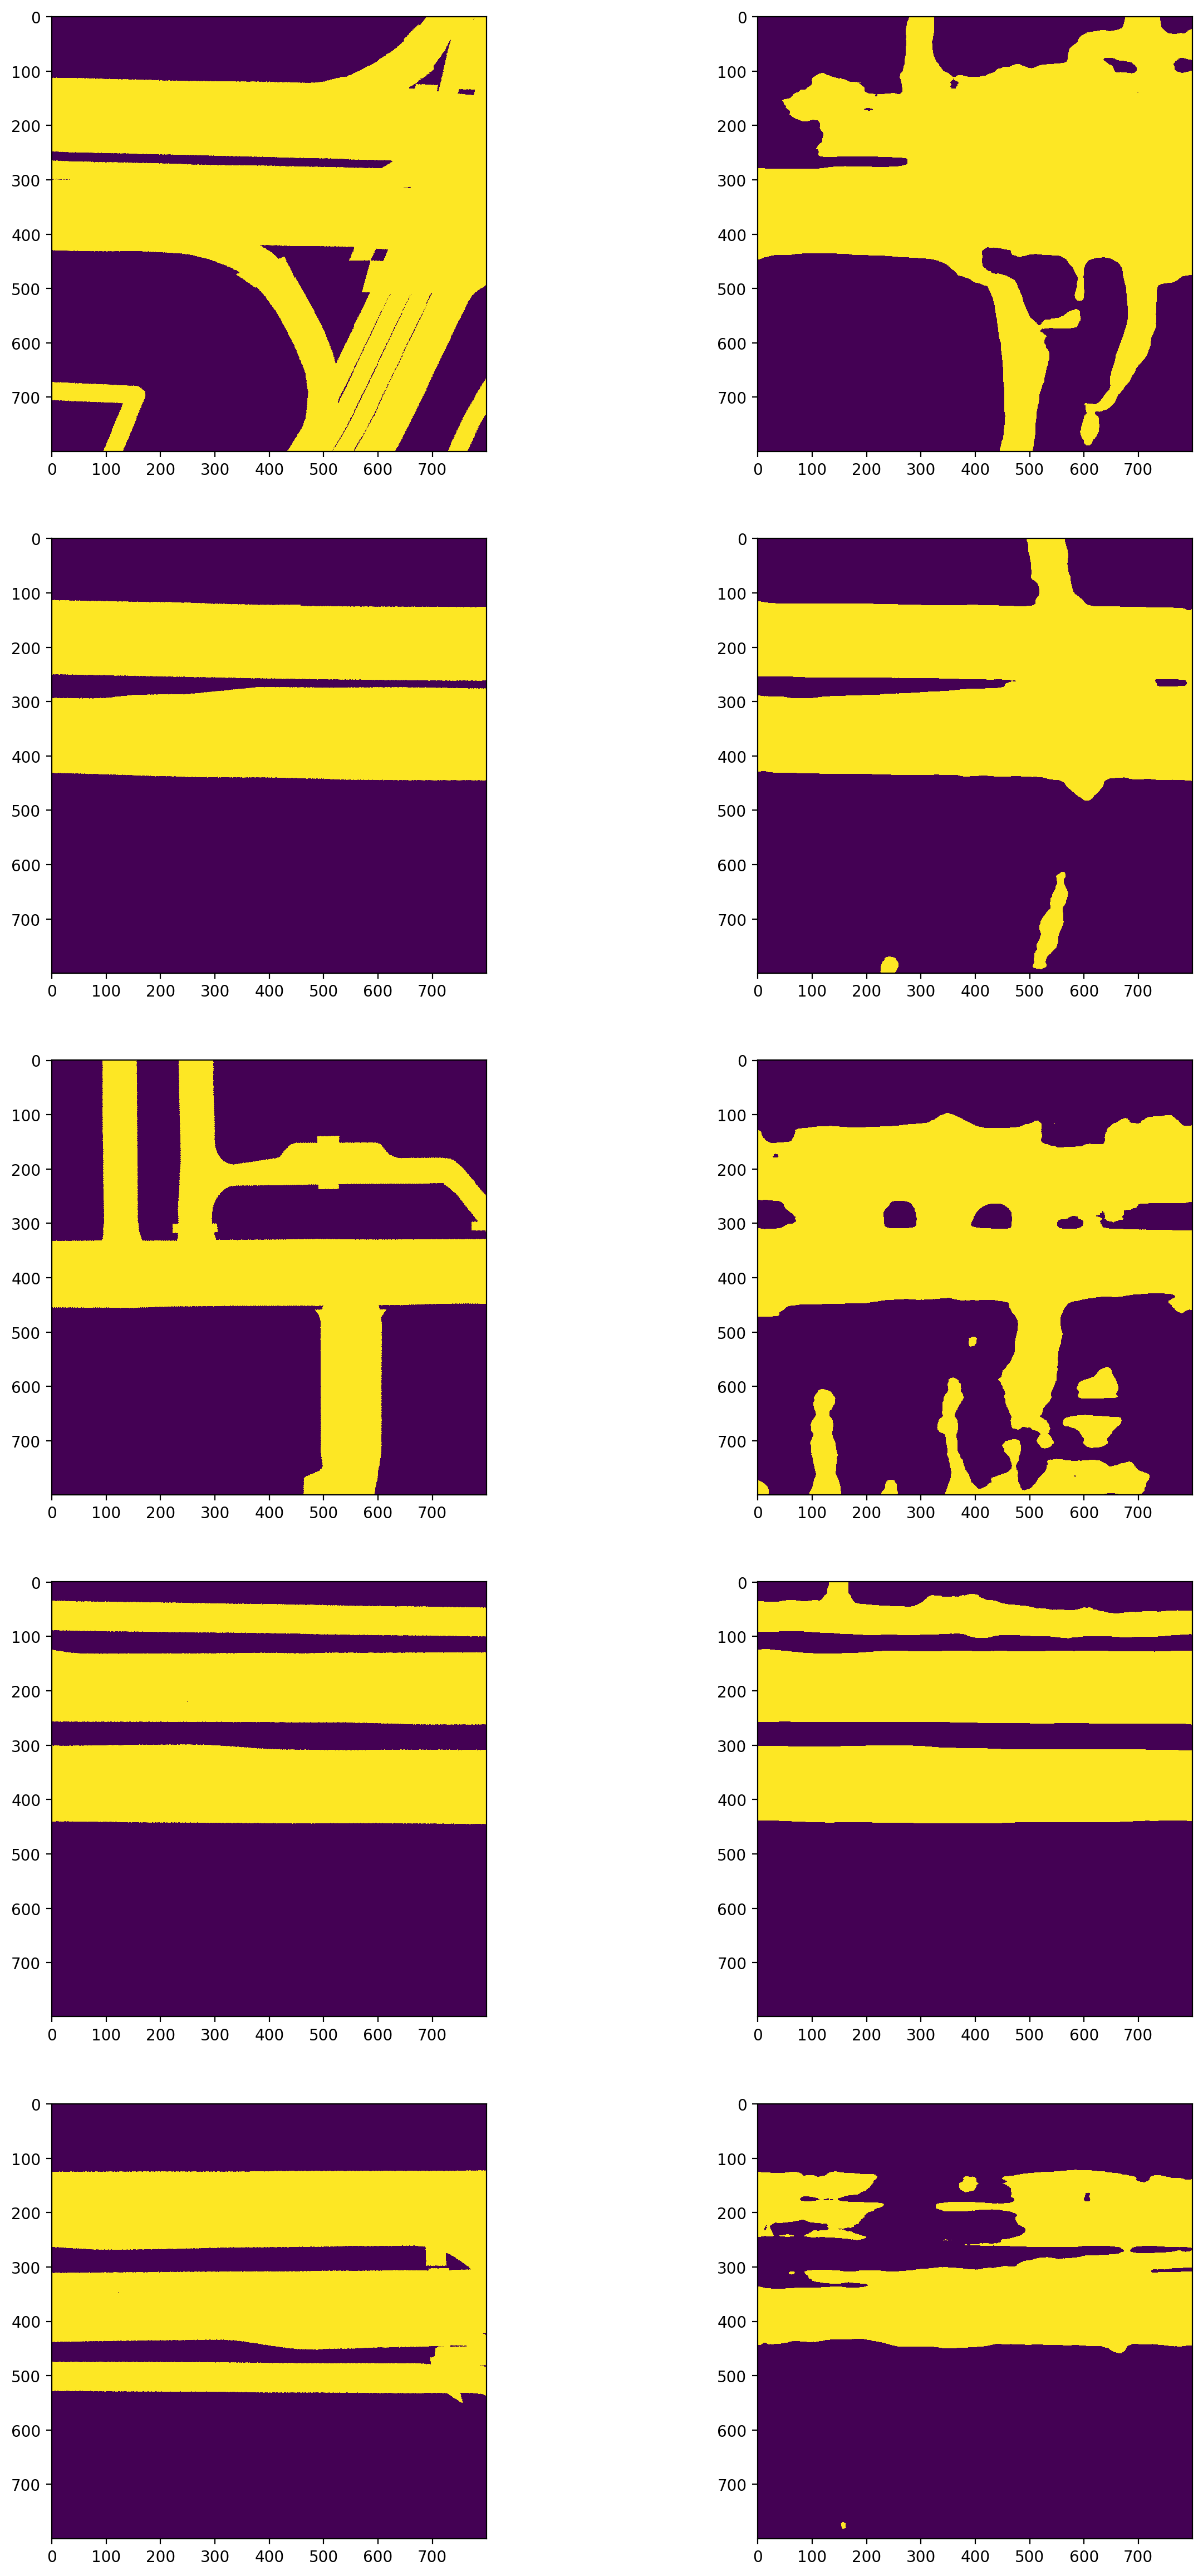

Epoch 32/40
----------
current epoch train composite loss is 42.194344
current epoch train dice coef is 1364.902954
training 1 epoch takes 23.041647 min
current epoch val composite loss is 98.640427
current epoch val dice coef is 202.679779
valing 1 epoch takes 24.463222 min
current ts is 0.697143
Epoch 33/40
----------
current epoch train composite loss is 41.253412
current epoch train dice coef is 1365.372070
training 1 epoch takes 23.000906 min
current epoch val composite loss is 103.956025
current epoch val dice coef is 200.021896
valing 1 epoch takes 24.426876 min
current ts is 0.680016
Epoch 34/40
----------
current epoch train composite loss is 40.398924
current epoch train dice coef is 1365.802246
training 1 epoch takes 23.040198 min
current epoch val composite loss is 101.253496
current epoch val dice coef is 201.373322
valing 1 epoch takes 24.479237 min
current ts is 0.689228
Epoch 35/40
----------
current epoch train composite loss is 39.546876
current epoch train dice coef 

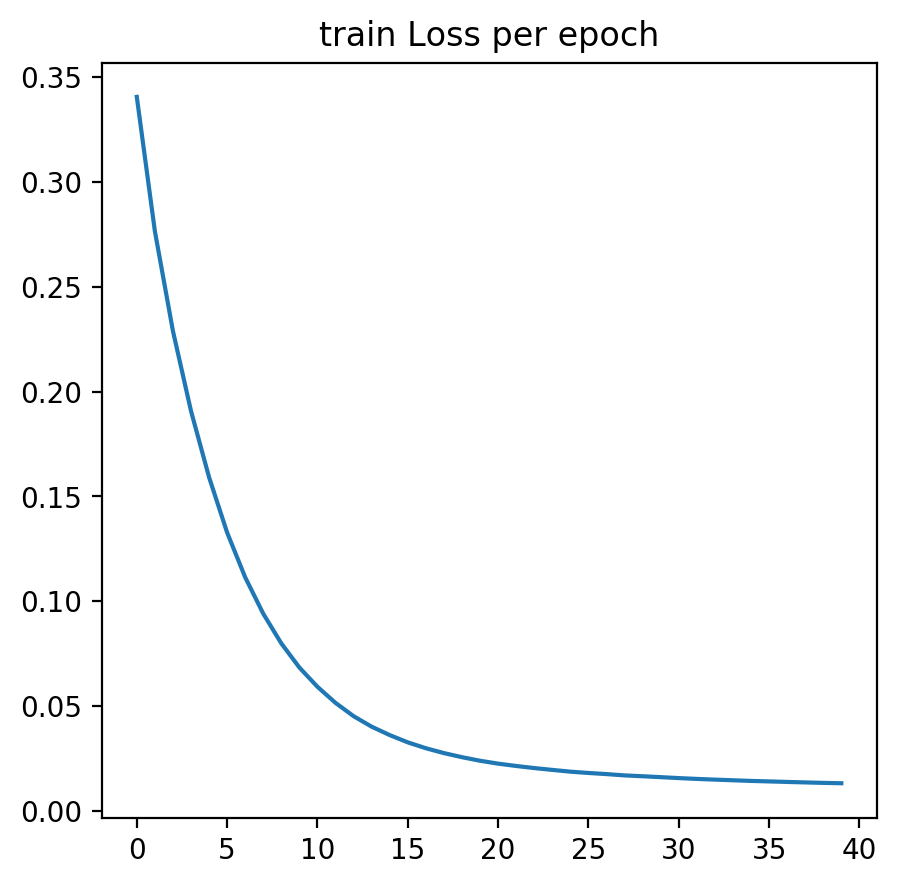

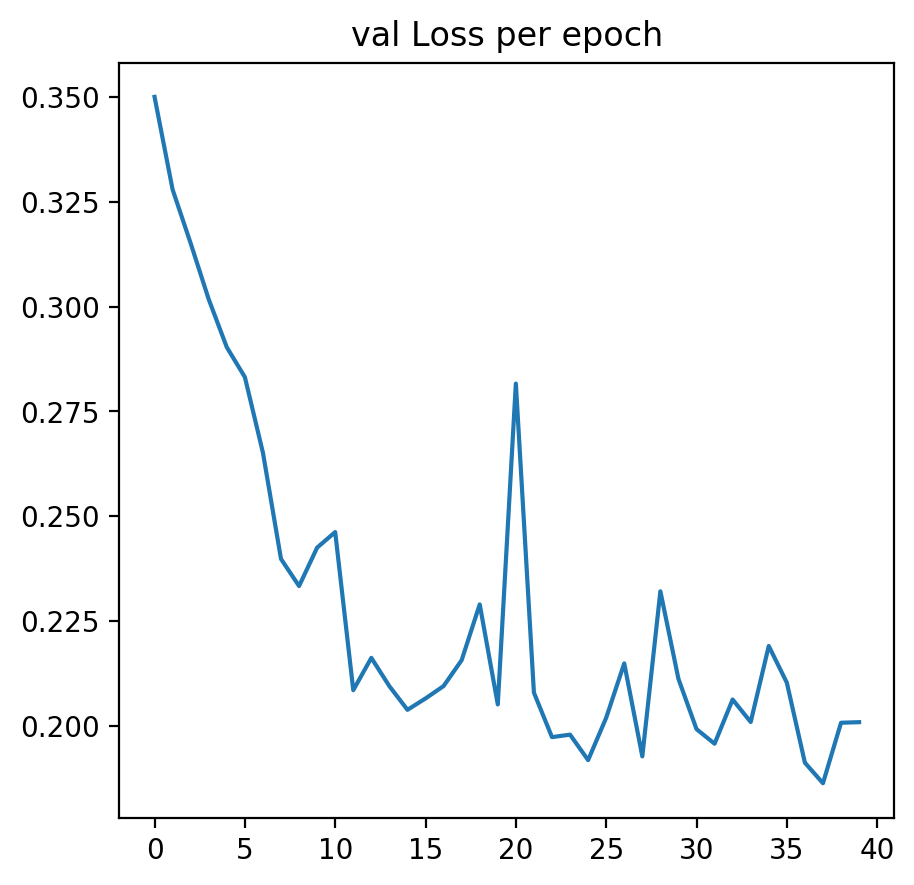

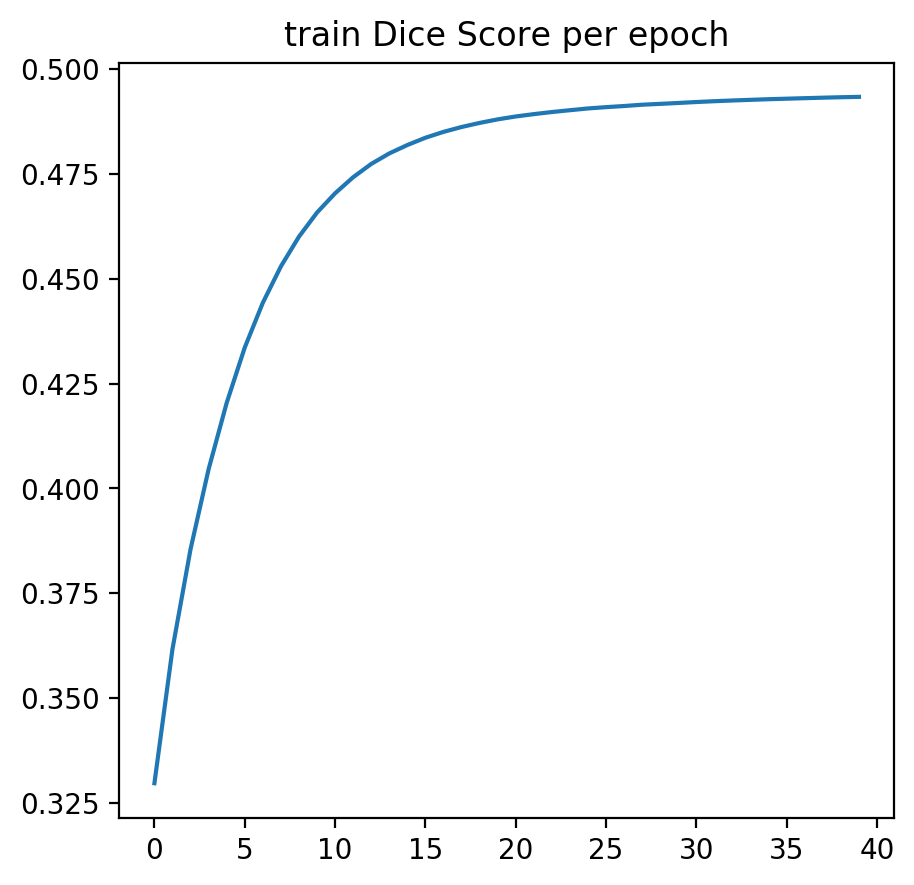

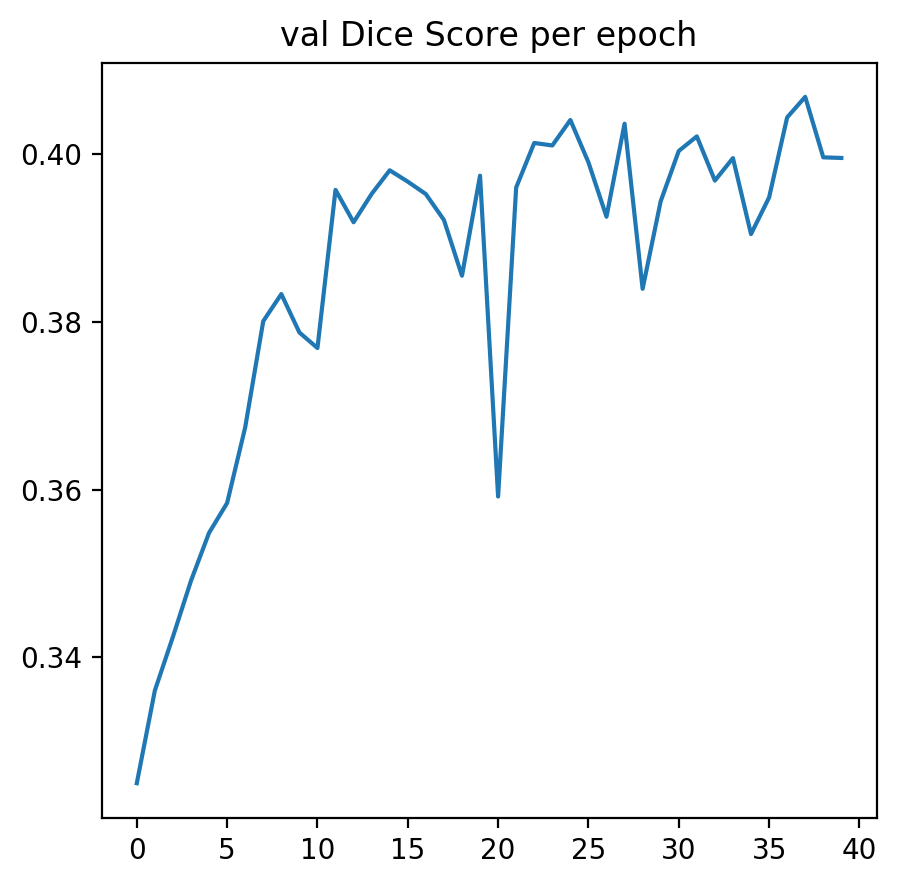

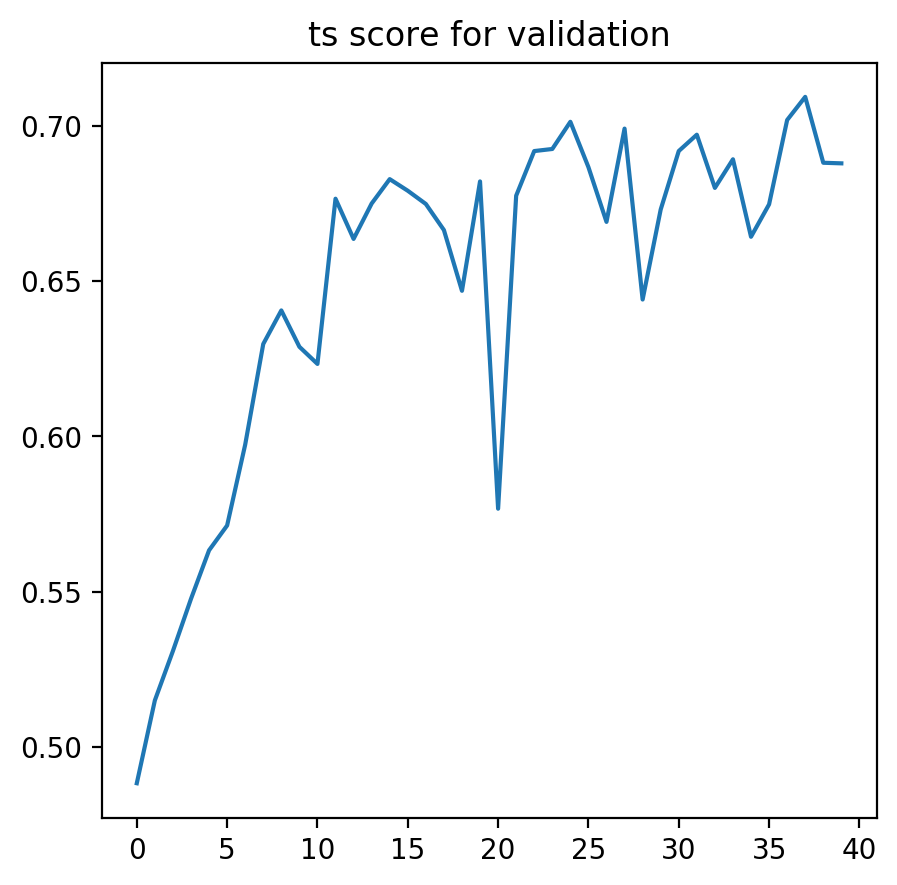

In [19]:
model, loss_dict, dice_dict, ts_dict = train_eval_model(my_model, dataloaders, 
                                                        dice_loss, optimizer, 
                                                        num_epochs=40, checkpoint=None, 
                                                        to_save = '/scratch/ht1162/DLResult/inpainting_resnet50_w_vae2.pth', 
                                                        print_every=10, 
                                                        eval_every = 1, to_eval = True)